In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras.datasets import boston_housing
from keras import models, layers
import numpy as np

Using TensorFlow backend.


In [2]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

# Properties of the loaded data (information from the internet)

1. CRIM - per capita crime rate by town
2. ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
3. INDUS - proportion of non-retail business acres per town.
4. CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
5. NOX - nitric oxides concentration (parts per 10 million)
6. RM - average number of rooms per dwelling
7. AGE - proportion of owner-occupied units built prior to 1940
8. DIS - weighted distances to five Boston employment centres
9. RAD - index of accessibility to radial highways
10. TAX - full-value property-tax rate per USD 10,000
11. PTRATIO - pupil-teacher ratio by town
12. B - 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
13. LSTAT - % lower status of the population
14. MEDV - Median value of owner-occupied homes in USD 1000's

# Targets in kUSD

Inspecting the data

In [3]:
# Shape of the data sets
print(train_data.shape)
print(test_data.shape)
print("")


# Shape of the targets
print(train_targets.shape)
print("")

# min / max / mean of the data sets
print(np.min(train_data, axis=0))
print("")
print(np.max(train_data, axis=0))
print("")
print(np.mean(train_data, axis=0))

(404, 13)
(102, 13)

(404,)

[6.3200e-03 0.0000e+00 4.6000e-01 0.0000e+00 3.8500e-01 3.5610e+00
 2.9000e+00 1.1296e+00 1.0000e+00 1.8800e+02 1.2600e+01 3.2000e-01
 1.7300e+00]

[ 88.9762 100.      27.74     1.       0.871    8.725  100.      10.7103
  24.     711.      22.     396.9     37.97  ]

[3.74511057e+00 1.14801980e+01 1.11044307e+01 6.18811881e-02
 5.57355941e-01 6.26708168e+00 6.90106436e+01 3.74027079e+00
 9.44059406e+00 4.05898515e+02 1.84759901e+01 3.54783168e+02
 1.27408168e+01]


# Normalization of the train data

The train data needs to be normalized.  

However, it needs to be normalized featurewise / columnwise.

In [4]:
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

# min / max / mean of the data sets
print(np.min(train_data, axis=0))
print("")
print(np.max(train_data, axis=0))
print("")
print(np.mean(train_data, axis=0))

[-0.40510053 -0.48361547 -1.56469648 -0.25683275 -1.47126853 -3.81725032
 -2.36904226 -1.28750316 -0.97156928 -1.31131055 -2.67375227 -3.77110135
 -1.51966384]

[9.23484718 3.72899018 2.44537425 3.89358447 2.67733525 3.46718635
 1.11048828 3.43740568 1.67588577 1.83609694 1.60353052 0.44807713
 3.48201936]

[-1.01541438e-16  1.09923072e-17  1.80933376e-15 -7.80453809e-17
 -5.25047552e-15  6.43187374e-15  2.98441140e-16  4.94653823e-16
  1.12671149e-17 -1.05526149e-16  2.36614908e-14  5.96710525e-15
  6.13920356e-16]


# Normalization of the test data

Normalize by the values extracted from the train data.  

##### Why not normalizing by values from the merged data set? 

##### -> information leakage

##### Why not normlizing by values from the test data set?

##### -> network will be trained on values of the train data

In [5]:
test_data -= mean
test_data /= std

# Building the model

In [15]:
def build_model():
    model = models.Sequential()
    
    model.add(layers.Dense(
        64, # output units <- initialize by guessing
        activation="relu",
        input_shape=(train_data.shape[1], )
    ))
    
#    model.add(layers.Dense(
#        64, 
#        activation="relu"
#    ))
    
    model.add(layers.Dense(
        1, 
        #activation="linear" <- default    
    ))
    
    model.compile(
        optimizer="rmsprop", # <- gradient decent (changes biases & weights)
        loss="mse",          # mean squared error 
        metrics=["mae"]      # mean absolute error
    )    
    
    return model
    
#model = build_model()
#model.summary()

## Explanation of the compile-parameter choice

mse(y_pred, y_true) := average((y_pred - y_true)²)

mae(y_pred, y_true) := average(y_pred - y_true)

# Validation data needs to be split from the train data

Less amount of data 

###### -> use k-fold cross validation (k-times training on differently splitted test / validation data)

In [23]:
k = 4 

num_val_samples = len(train_data) // k
num_epochs = 800
all_scores = []

histories = []

for i in range(k):
    print("Proccessing fold", i)
    
    val_data    = train_data[i * num_val_samples: (i+1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]
    
    data_left = train_data[0: i * num_val_samples]
    data_right = train_data[(i+1) * num_val_samples: ]    
    partial_train_data = np.concatenate([data_left, data_right], axis=0)
    
    targets_left = train_targets[0: i * num_val_samples]
    targets_right = train_targets[(i+1) * num_val_samples: ]    
    partial_train_targets = np.concatenate([targets_left, targets_right], axis=0)
    
    model = build_model()
    
    history = model.fit(
        partial_train_data, partial_train_targets, 
        epochs = num_epochs,
        batch_size = 1,
        verbose=0, # no output!    
        validation_data = (val_data, val_targets)
    )
    histories.append(history)
    all_scores.append(history.history["val_mean_absolute_error"][-1])
    
    #val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    #all_scores.append(val_mae)   
print(all_scores)

Proccessing fold 0
Proccessing fold 1
Proccessing fold 2
Proccessing fold 3
[2.433506979800687, 3.260848054791441, 3.0320095779872176, 2.617308937677062]


In [30]:
from matplotlib.pyplot import cm


color1=cm.Blues(np.linspace(1,0,k+1))
color2=cm.Oranges(np.linspace(1,0,k+1))

linestyles = ['-',':', '-.', '--']

def plot_history(histories):
    counter = 0
    for his in histories:
        history = his.history
        #plt.plot(history["mean_absolute_error"], color=color1[1+counter], ls = linestyles[counter], label="mae"+str(counter))
        plt.plot(history["val_mean_absolute_error"], color=color2[1+counter], ls = linestyles[counter], label="val_mae"+str(counter))
        counter+=1
        plt.legend()
    plt.show()
    plt.close()
    counter = 0
    for his in histories:
        history = his.history
        #plt.plot(history["loss"], color=color1[1+counter], ls = linestyles[counter], label="loss"+str(counter))
        plt.plot(history["val_loss"], color=color2[1+counter], ls = linestyles[counter], label="val_loss"+str(counter))
        counter+=1
        plt.legend()
    plt.show()
    plt.close()

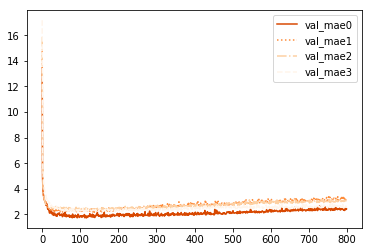

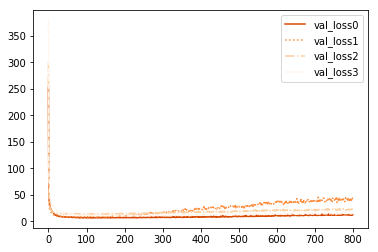

In [34]:
plot_history(histories)

In [35]:
def plot_history(histories, epochs = 10):
    
    fig, ax = plt.subplots(nrows=5, ncols=2, figsize = (20,20)) # generate single canvas for all plots
    
    for ix,row in enumerate(ax):
        if ix < 4: # first four represent individual folds
            fold_data = histories[ix]
            for col, measure in zip(row, ['losses', 'error']): # data unwinds in losses and error
                if measure == 'losses':
#                     col.plot(fold_data['loss'], label = 'train_mse')
                    col.plot(fold_data['val_loss'], label = 'validation_mse')
                    col.legend()
                else:
                    col.plot(fold_data['val_mean_absolute_error'], label = 'val_mae')
#                     col.plot(fold_data['mean_absolute_error'], label = 'train_mae')
                    col.legend()
       
        else:
            # Here we combine the plot to see them adjacently on a single subplot
            for col, measure in zip(row, ['losses', 'error']):
                if measure == 'losses':
                    for index, each in enumerate(histories):
#                         col.plot(each['loss'], label = 'Training loss {}'.format(str(index)))
                        col.plot(each['val_loss'], label = 'Validation loss {}'.format(str(index)))
                        if index == 3:
                            col.legend()
                else:
                    for index, each in enumerate(histories):
                        col.plot(each['val_mean_absolute_error'], label = 'Validation err. {}'.format(str(index)))
#                         col.plot(each['mean_absolute_error'], label = 'Training err. {}'.format(str(index)))
                        if index == 3:
                            col.legend()
    
                        
    fig.suptitle('{} Epochs'.format(str(epochs)), fontsize= 60)
    plt.show()
    plt.close()

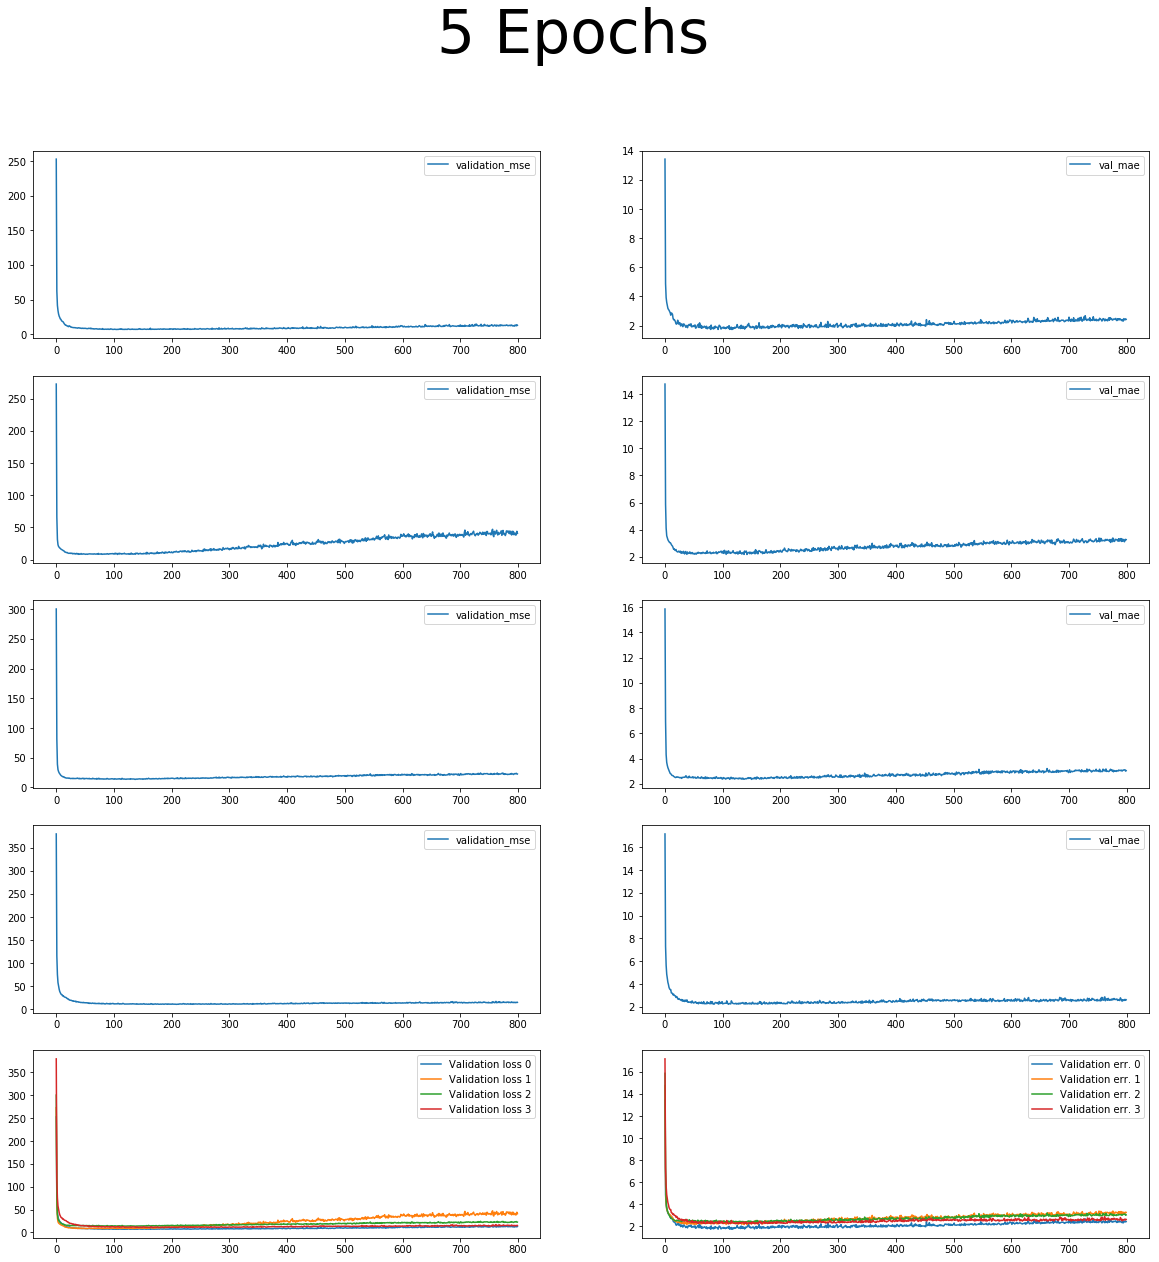

In [47]:
hist = []
for i in range(k):
    hist.append(histories[i].history)


plot_history(hist, epochs = 5)